<a href="https://colab.research.google.com/github/CDU-data-science-team/zero-shot/blob/development/Multilabeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
---

This is a multilabel classification task that output the degree of confidence (probability) a trained model has about a row of feature belonging to a particular class its trained on. 

The aim of this project is to categories patient feedbacks into different categories used within our trust. This was initiated out of curiosity that a feedback can fall into one or more category just as a movie can fall under different  genres. 

To carry our this task we followed the steps below.
---
**A. Multilabel Classification**

We have a dataset with over 10,000 rows of customers feedbacks that has been manaually single labeled by the coders in our trust. This dataset falls under multiclassification task but our project require a multilabeled dataset for multilabel classification.

1. The pipeline convert our singlelabel dataset (multiclass classification problem) into multilabel dataset. This step was neccesary because we lack quality multilabeled dataset at the moment

  * This is done by using LabelBinariser function to output a matrix for each row

2. The multilabel dataset can then be used to train a multilabel model 

3. the model can be use to make prediction on set of comments/feedbacks to output prediction/probabilities 

4. the model was used to output multilabel probabilities for  the whole feedbacks in the orignal dataset

**B. To generate the categories each row falls into**
* We itererate through each row and assigned to the row any category with probability value above our threshold value 
* Our threshold value is either 0.5 or the seventy-fifth percentile value (of that row probabilities)

Three main approaches were explored and they all produced diffrent accuracy metric. 

## Needed libraries

In [1]:
!pip install scikit-multilearn      #the library that we will use to perform multi-label text classification.
!python -m spacy download en_core_web_md      # medium size english model for spacy

     |████████████████████████████████| 89 kB 2.9 MB/s 
     |████████████████████████████████| 96.4 MB 1.1 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=8785b3b47281d012a8f406ee58748194cea4f31f8a416c93a6d2242725c6f516
  Stored in directory: /tmp/pip-ephem-wheel-cache-essehc7m/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [2]:
# Data manipulation
import pandas as pd
import numpy as np 

# Preprocessing
import re
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import time

import warnings
warnings.filterwarnings('ignore')             # to suppress all warnings

# Tfidf
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet') 
stop_word = set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer

# model wrapper for multilabel classification
from skmultilearn.problem_transform import LabelPowerset

# classification model
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, hamming_loss

# Address class imbalance in the training Dataset
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Word embedding
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
import en_core_web_md
nlp = en_core_web_md.load() 

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Needed functions 

In [3]:
######################################################### Needed Function
def text_preprocessor(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    '''
    Preprocess a string.
    :parameter
      :param text: string - name of column containing text
      :param lst_stopwords: list - list of stopwords to remove
      :param flg_stemm: bool - whether stemming is to be applied
      :param flg_lemm: bool - whether lemmitisation is to be applied
    
    :return
      cleaned text
    '''
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    # Remove any excess whitespaces
    text = re.sub(" +", " ", text)
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()

    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

# Define a function for evaluating the model
def class_balance_accuracy_score(y_true, y_pred):
    """
    Function for Class Balance Accuracy scorer
    (p. 40 in `Mosley 2013 <https://lib.dr.iastate.edu/cgi/viewcontent.cgi?article=4544&context=etd>`_).
    copied from: `pxtextmining package <https://github.com/CDU-data-science-team/pxtextmining/blob/main/pxtextmining/helpers/metrics.py>`
    :param array y_true: True classes, shape = [n_samples].
    :param array y_pred: Predicted classes, shape = [n_samples].
    :return: cba (`float`): The Class Balance Accuracy score.
    """

    cm = confusion_matrix(y_true, y_pred)
    c_i_dot = np.sum(cm, axis=1)
    c_dot_i = np.sum(cm, axis=0)
    cba = []
    for i in range(len(c_dot_i)):
        cba.append(cm[i][i] / max(c_i_dot[i], c_dot_i[i]))
    cba = sum(cba) / (i + 1)
    return cba

def acc_h_loss_scorer (y_true, y_pred):
  acc = round(accuracy_score(y_true, y_pred), 2)
  h_loss = round(hamming_loss(y_true,y_pred), 2)
  return acc, h_loss

def print_metric (X, Y, message=None, multilabel=False):
  print(message)
  acc, h_loss = acc_h_loss_scorer(X,Y)
  print('Overall model accuracy is {}'.format(acc))   # explore the model performance on the test data
  print('Overall model hamming loss is {}'.format(h_loss))   # explore the model performance on the test data
  if not multilabel:
    b_acc = round(balanced_accuracy_score(X,Y), 2)
    cl_bal_acc = round(class_balance_accuracy_score(X,Y), 2)
    print('Overall model Balance accuracy is {}'.format(b_acc))   # explore the model performance on the test data
    print('Overall model Class Balance accuracy is {}'.format(cl_bal_acc))   # explore the model performance on the test data

def plot_metric (acc, h_loss, title=None, ax=None):
  sns.barplot(x=['Accuracy', 'hamming_loss'], y=[acc, h_loss], ax=ax).set(title=title,) 

def tagger (all_pred_prob, high_threshold=0.5, print_metrics=True):
  """
    Function for assigning rows to diffrenct categories

    :parameter
      :param n_class matrix all_pred_prob: predicted probability matrix, shape = [n_samples, n_classes].
      :param float high_threshold: threshold to use to assign category to rows
      :param bool print_metrics: wheater to print total number of rows with multilabel and visualise the no of labels/total number of sample
    :return
      tags (`list`): list of tags, shape = [n_samples].
  """
  high = high_threshold
  multilabel_counter = 0
  label_counter = []
  multilabel_rowindex = []
  multi_label = []
  le = LabelEncoder().fit(df.label)

  for i, p in enumerate(all_pred_prob): # itererate over each row 
    # set the threshold to be either high or the seventy-fifth percentile   
    seventh = np.percentile(p, [75]) 
    if max(p) > high:
      threshold = high
    else:
      threshold = seventh
    best_labels_dict = {k:v for k,v in enumerate(p) if v>threshold}    # extract  as a dictionary the index and values of probaility greater than the threshold percentage
    best_labels_id = sorted(best_labels_dict, key=best_labels_dict.get, reverse=True) # Extract the label code(best_labels_dict.keys) arranged in decreasing order of their probability values
    best_label = le.inverse_transform(best_labels_id)                  # convert the label code into the original class names   
    multi_label.append(', '.join(best_label))

    if print_metrics:
      label_counter.append(len(best_label))
      if len(best_label) > 1:
          multilabel_counter+=1
          multilabel_rowindex.append(i)
  
  if print_metrics:
    print('Number of rows with MultiLabel is ', multilabel_counter)
    # Visualization
    sns.countplot(x=label_counter).set(xlabel='no of labels', ylabel='no of samples', title='No of label per Feedback')
  return multi_label

## Needed Classes

In [4]:
class WordVectorTransformer(TransformerMixin,BaseEstimator):
  '''
  Class for converting text into `GloVe <https://nlp.stanford.edu/projects/glove/>`_ word vectors
  Helpful class that can be used in `sklearn pipeline`
  '''
  def __init__(self, model=None):
      self.model = model

  def fit(self,X,y=None):
      return self

  def transform(self,X):
      X_processed = [text_preprocessor(doc) for doc in X]
      return np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in X_processed])

# Exploratory Data Analysis

,text_lenght
count,10333.000000
mean,13.343076
std,19.077026
min,1.000000
25%,4.000000
50%,8.000000
75%,16.000000
max,467.000000


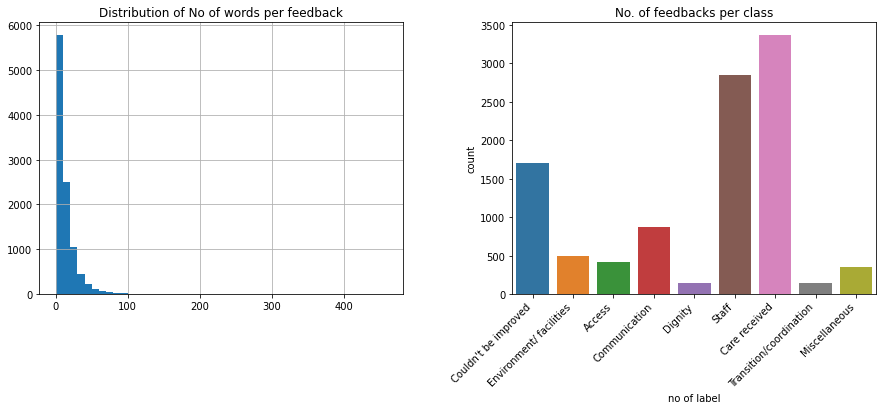

In [5]:
#Load data
url = 'https://raw.githubusercontent.com/CDU-data-science-team/pxtextmining/main/datasets/text_data.csv'
df = pd.read_csv(url, usecols=['feedback', 'label'],  encoding='utf-8')#, nrows=100)
df.dropna(inplace=True)

# preprocess the data and split to train, test
df['text_lenght'] = [len(x.split()) for x in df.feedback] 
texts = df[['feedback', 'text_lenght']]

fig, ax = plt.subplots(1,2, figsize=(15,5))
df.hist(bins = np.arange(0,max(df.text_lenght),10), ax=ax[0])
ax[0].set(title='Distribution of No of words per feedback',)
sns.countplot(df.label, ax=ax[1]).set(xlabel='no of label', title='No. of feedbacks per class',)
plt.xticks(rotation = 45, ha='right')

df.describe()

# Multilabeling using Label Powerset wrapper

In [6]:
%%time
# Load in the data
url = 'https://raw.githubusercontent.com/CDU-data-science-team/pxtextmining/main/datasets/text_data.csv'
df = pd.read_csv(url, usecols=['feedback', 'label'],  encoding='utf-8')#, nrows=100)
df.feedback.fillna('', inplace=True)

# ============================================= For Multilabel Classification ===============================================================
# Preprocess the single labelled dataset into a multilabel dataset
lb = LabelBinarizer().fit(df.label)
classes = lb.transform(df.label)
class_df = pd.DataFrame(classes, columns=lb.classes_)
df = pd.concat([df, class_df], axis=1)
# ============================================================================================================

# Split the data into train and test set
X = df.feedback
Y = df.iloc[:,-9:].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.33, shuffle=True)

# Define the model 
# Approach accuracy (from testing): Single  is 0.71, BinaryRelevance is 0.54, ClassifierChain accuracy is 0.66, LabelPowerset accuracy is 0.7 (takes 55mins)
# model = SVC(kernel='rbf', probability=True)  
model = LogisticRegression(random_state=1)      # Single accuracy is 0.68, Multilab accuracy is 0.5

# Define the pipeline (take a label matrix dataset and output label matrix during prediction)
Label_PS_pipeline = Pipeline([
               ('tfidf', TfidfVectorizer(stop_words=stop_word)),       # produce best metric from pre_testing
              #  ('wdemb', WordVectorTransformer()),
              #  ('clf', LabelPowerset(model, require_dense=[True, True])),
               ('clf', LabelPowerset(model)),
                ])

# Model training and prediction
Label_PS_pipeline.fit(X_train,y_train)
lb_prediction = Label_PS_pipeline.predict(X_test)#.toarray()

# Print Metric
print_metric(y_test, lb_prediction, message='Test Metrics', multilabel=True)
print('='*60)

# Multi-label prediction on the full dataset
print('\nPredicting for Multilabeling') 
prob_Y = Label_PS_pipeline.predict_proba(X).toarray()
print('\nRowSum is ', max(sum(prob_Y.T)), '\n')                # To prove the probabilities across each row didn't auto add up to 1
tags = tagger (prob_Y, high_threshold=0.5, print_metrics=False)
df['tag'] = tags
print('='*60)

# combine the data
prob_df = pd.DataFrame(prob_Y, columns=lb.classes_)
df = pd.concat([df, prob_df], axis=1)

# # export the data
# df.to_csv('MultiLa_data.csv')
df.head()

Test Metrics
Overall model accuracy is 0.69
Overall model hamming loss is 0.07

Predicting for Multilabeling

RowSum is  1.0000000000000004 

CPU times: user 55.7 s, sys: 14.2 s, total: 1min 9s
Wall time: 37.7 s


# Multi-label classification approach without oversampling and multilabel wrapper


Training the Model
... Processing Access
Test accuracy is 0.9610085019055995
all data accuracy is 0.9623572672730791
... Processing Care received
Test accuracy is 0.7936089123424216
all data accuracy is 0.8250435455777047
... Processing Communication
Test accuracy is 0.9340369393139841
all data accuracy is 0.9378749758080124
... Processing Couldn't be improved
Test accuracy is 0.9416593374377016
all data accuracy is 0.9466808592994
... Processing Dignity
Test accuracy is 0.9850483729111698
all data accuracy is 0.9866460228372363
... Processing Environment/ facilities
Test accuracy is 0.9639401934916447
all data accuracy is 0.9618734275208051
... Processing Miscellaneous
Test accuracy is 0.9742011140428027
all data accuracy is 0.973582349525837
... Processing Staff
Test accuracy is 0.8501905599530929
all data accuracy is 0.8707180181923747
... Processing Transition/coordination
Test accuracy is 0.9862210495455878
all data accuracy is 0.9859686471840526

Predicting for Multilabeling
Num

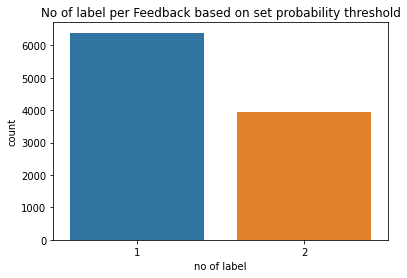

In [7]:
# Load in the data
url = 'https://raw.githubusercontent.com/CDU-data-science-team/pxtextmining/main/datasets/text_data.csv'
df = pd.read_csv(url, usecols=['feedback', 'label'],  encoding='utf-8')#, nrows=100)
df.feedback.fillna('', inplace=True)

# Preprocess the single labelled dataset into a multilabel dataset and split the data into train and test set 
lb = LabelBinarizer().fit(df.label)
le = LabelEncoder().fit(df.label)    # create the label encoder object(needed for converting our prediction back to the text labels)
classes = lb.transform(df.label)
class_df = pd.DataFrame(classes, columns=lb.classes_)
df = pd.concat([df, class_df], axis=1)

train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
X_train = train.feedback
X_test = test.feedback

# Define a pipeline combining a text feature extractor with multi lable classifier
LogReg_pipeline = Pipeline([
               ('tfidf', TfidfVectorizer(stop_words=stop_word)),
               ('clf', LogisticRegression(solver='sag')),
               ])

print('\nTraining the Model')
for category in lb.classes_:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))   # explore the model performance on the test data
    
    # print('\nPredicting probability on full dataset')
    all_prediction = LogReg_pipeline.predict(df.feedback)
    print('all data accuracy is {}'.format(accuracy_score(df[category], all_prediction))) # explore the model performance on all the data
    probs = LogReg_pipeline.predict_proba(df.feedback)[:,1]    # keep the probabilities for class 1
    df[category] = probs                      # extract the probabilities for label 1 (the value that represent that the row belongs to the specified class)
    print('='*40)

# Extract all probability as an array
all_pred_prob = df.iloc[:, -9:].values

# Multi-label prediction on the full dataset
print('\nPredicting for Multilabeling') 
high = 0.5
multilabel_counter = 0
label_counter = []
multilabel_rowindex = []
for i, p in enumerate(all_pred_prob): # itererate over each row 
  # set the threshold to be either high or the seventy-fifth percentile   
  seventh = np.percentile(p, [75]) 
  if max(p) > high:
    threshold = high
  else:
    threshold = seventh
  best_labels_dict = {k:v for k,v in enumerate(p) if v>threshold}    # extract  as a dictionary the index and values of probaility greater than the threshold percentage
  best_labels_id = sorted(best_labels_dict, key=best_labels_dict.get, reverse=True) # Extract the label code(best_labels_dict.keys) arranged in decreasing order of their probability values
  best_label = le.inverse_transform(best_labels_id)                  # convert the label code into the original class names   
  label_counter.append(len(best_label))      
  df.loc[i,'multi_label'] = ', '.join(best_label)

  if len(best_label) > 1:
      multilabel_counter+=1
      multilabel_rowindex.append(i)

print('Number of rows with MultiLabel is ', multilabel_counter) 
print('Maximum rowsum of probabilities is ', round(max(df.iloc[:, -9:].sum(axis=1)),2))    # To prove the probabilities across each row didn't auto add up to 1
print('='*40)

# Single Labeling 
print('\nPredicting for Single_labeling') 
predt = np.argmax(all_pred_prob, axis=-1)
predt = le.inverse_transform(predt)                  # convert the label code into the original class names   
df['Single_label'] = predt
print('='*40)

print('\n')
print('Overall model accuracy is {}'.format(accuracy_score(df['label'], predt)))   # explore the model performance on the test data
print('Overall model Balance accuracy is {}'.format(balanced_accuracy_score(df['label'], predt)))   # explore the model performance on the test data
# print('Overall model Class Balance accuracy is {}'.format(class_balance_accuracy_score(df['label'], predt)))   # explore the model performance on the test data
print('='*40)

# Visualization
sns.countplot(x=label_counter).set(xlabel='no of label', title='No of label per Feedback based on set probability threshold')
df.head()

# export the data
# df.to_csv('MultiLa_data.csv')

# Multi-label classification approach with oversampling and without multilabel wrapper
Each row probabilities don't neccesarily add up to 1



...Address class imbalance in the training Dataset
Original dataset shape Counter({'Care received': 2291, 'Staff': 1881, "Couldn't be improved": 1123, 'Communication': 587, 'Environment/ facilities': 346, 'Access': 273, 'Miscellaneous': 233, 'Transition/coordination': 98, 'Dignity': 91})
New dataset shape Counter({'Care received': 2291, 'Staff': 2291, 'Communication': 2291, "Couldn't be improved": 2291, 'Environment/ facilities': 2291, 'Transition/coordination': 2291, 'Miscellaneous': 2291, 'Access': 2291, 'Dignity': 2291})


Training the Model
... Processing Access
Test accuracy is 0.9627675168572266
all data accuracy is 0.9792916586026708
... Processing Care received
Test accuracy is 0.7534447376136031
all data accuracy is 0.7586607315657055
... Processing Communication
Test accuracy is 0.9369686309000294
all data accuracy is 0.9538416876330559
... Processing Couldn't be improved
Test accuracy is 0.9366754617414248
all data accuracy is 0.9433907489839365
... Processing Dignity
Test 

,label,feedback,Access,Care received,Communication,Couldn't be improved,Dignity,Environment/ facilities,Miscellaneous,Staff,Transition/coordination,multi_label,Single_label
0,Couldn't be improved,Nothing.,0.001334,0.000644,0.001601,0.979485,0.001334,0.001742,0.040319,0.000828,0.001804,Couldn't be improved,Couldn't be improved
1,Environment/ facilities,Temperature in theatre a little low.,0.045084,0.044368,0.051480,0.061527,0.013659,0.683922,0.049102,0.042633,0.016777,Environment/ facilities,Environment/ facilities
2,Access,Same service available at Bingham Health Centre.,0.822400,0.057418,0.047425,0.033526,0.006414,0.052731,0.027434,0.030910,0.020815,Access,Access
3,Communication,Appointment details given over phone - no phys...,0.066495,0.188783,0.057147,0.063971,0.003406,0.013132,0.068410,0.037125,0.015508,"Care received, Miscellaneous",Care received
4,Communication,On one occasion I was not made aware that my a...,0.207299,0.090750,0.510717,0.021687,0.007170,0.038779,0.007069,0.020708,0.151835,Communication,Communication


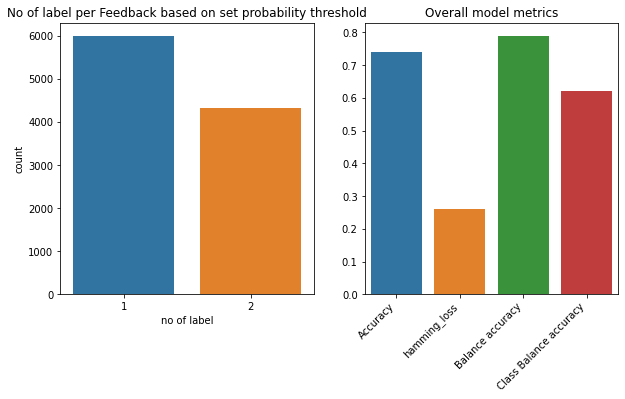

In [8]:
# Load in the data
url = 'https://raw.githubusercontent.com/CDU-data-science-team/pxtextmining/main/datasets/text_data.csv'
df = pd.read_csv(url, usecols=['feedback', 'label'],  encoding='utf-8')#, nrows=100)
df.feedback.fillna('', inplace=True)

# Preprocess the single labelled dataset into a multilabel dataset and split the data into train and test set 
lb = LabelBinarizer().fit(df.label)
le = LabelEncoder().fit(df.label)    # create the label encoder object(needed for converting our prediction back to the text labels)
classes = lb.transform(df.label)
class_df = pd.DataFrame(classes, columns=lb.classes_)
df = pd.concat([df, class_df], axis=1)
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

print('\n...Address class imbalance in the training Dataset')
X_train = np.array(train.feedback).reshape(-1, 1)         # RandomOverSampler require a 2D array 
X_train, train_labels = RandomOverSampler(random_state=0).fit_resample(X_train, train.label)
proc_train = pd.DataFrame(np.column_stack([X_train, train_labels]),  columns=['feedback', 'label'])

# Explore number of samples in each class
print(f'Original dataset shape {Counter(train.label)}')
print(f'New dataset shape {Counter(proc_train.label)}')
print('='*40,'\n')

# # convert the training data to multiclass
train_classes = lb.transform(proc_train.label)
train_class_df = pd.DataFrame(train_classes, columns=lb.classes_)
train = pd.concat([proc_train, train_class_df], axis=1)

# Define a pipeline combining a text feature extractor with multi lable classifier
LogReg_pipeline = Pipeline([
               ('tfidf', TfidfVectorizer(stop_words=stop_word)),
               ('clf', LogisticRegression(solver='sag')),
               ])

X_train = train.feedback
X_test = test.feedback
print('\nTraining the Model')
for category in lb.classes_:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))   # explore the model performance on the test data
    
    # print('\nPredicting probability on full dataset')
    all_prediction = LogReg_pipeline.predict(df.feedback)
    print('all data accuracy is {}'.format(accuracy_score(df[category], all_prediction))) # explore the model performance on all the data
    probs = LogReg_pipeline.predict_proba(df.feedback)[:,1]    # keep the probabilities for class 1
    df[category] = probs                      # extract the probabilities for label 1 = represent that the row belongs to the specified class
    print('='*40)

# Extract all probability as an array
all_pred_prob = df.iloc[:, -9:].values

print('='*40)
print(all_pred_prob)
print('='*40)

# Multi-label prediction on the full dataset
print('\nPredicting for Multilabeling') 
high = 0.5
multilabel_counter = 0
label_counter = []
multilabel_rowindex = []
for i, p in enumerate(all_pred_prob): # itererate over each row 
  # set the threshold to be either high or the seventy-fifth percentile   
  seventh = np.percentile(p, [75]) 
  if max(p) > high:
    threshold = high
  else:
    threshold = seventh
  best_labels_dict = {k:v for k,v in enumerate(p) if v>threshold}    # extract  as a dictionary the index and values of probaility greater than the threshold percentage
  best_labels_id = sorted(best_labels_dict, key=best_labels_dict.get, reverse=True) # Extract the label code(best_labels_dict.keys) arranged in decreasing order of their probability values
  best_label = le.inverse_transform(best_labels_id)                  # convert the label code into the original class names   
  label_counter.append(len(best_label))      
  df.loc[i,'multi_label'] = ', '.join(best_label)

  if len(best_label) > 1:
      multilabel_counter+=1
      multilabel_rowindex.append(i)

print('Number of rows with MultiLabel is ', multilabel_counter) 
print('Maximum rowsum of probabilities is ', round(max(df.iloc[:, -9:].sum(axis=1)),2))    # To prove the probabilities across each row didn't auto add up to 1
print('='*40)

# Single Labeling 
print('\nPredicting for Single_labeling') 
predt = np.argmax(all_pred_prob, axis=-1)
predt = le.inverse_transform(predt)                  # convert the label code into the original class names   
df['Single_label'] = predt
print('='*40)

print('\n')
acc = round(accuracy_score(df['label'], predt), 2)
b_acc = round(balanced_accuracy_score(df['label'], predt), 2)
cl_bal_acc = round(class_balance_accuracy_score(df['label'], predt), 2)
h_loss = round(hamming_loss(df['label'], predt), 2)

print('Overall model accuracy is {}'.format(acc))   # explore the model performance on the test data
print('Overall model hamming loss is {}'.format(h_loss))   # explore the model performance on the test data
print('Overall model Balance accuracy is {}'.format(b_acc))   # explore the model performance on the test data
# print('Overall model Class Balance accuracy is {}'.format(cl_bal_acc))   # explore the model performance on the test data

print('='*40)

# Visualization
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.countplot(x=label_counter, ax=ax[0]).set(xlabel='no of label', title='No of label per Feedback based on set probability threshold')
sns.barplot(x=['Accuracy', 'hamming_loss', 'Balance accuracy', 'Class Balance accuracy'], y=[acc, h_loss, b_acc, cl_bal_acc], ax=ax[1]).set(title='Overall model metrics',)
plt.xticks(rotation = 45, ha='right')

# export the data
# df.to_csv('MultiLa_data.csv')
df.head()